# Objective
In this workbook, I use Python and pandas to explore 1.6MM observations from The Lending Club data, which Nathan George has kindly provided on Kaggle. This is an interesting dataset not only because of its sheer size, but because it includes much information about the borrowers, such as borrowers' current balance, FICO score, income, etc. This dataset is very similar to the Prosper dataset, but it is of a much larger size.

This notebook's main purpose is exploration. I do not seek to optimize for the performance metrics, but only want to explore the certain techniques, such as feature selection, sampling methods, etc.

The layout of this Notebook is as follows:
-  Simple data cleaning
-  Data Exploration
> Change of rates through time <br>
> Distribution of Income across grade <br>
> Income distribution by professions <br>
> FICO range and grade <br>
> Charge-off rate vs Verification status
-  Simple feature selection using GBM and Random Forest
-  Model run using a combination of:
> GBM, Random Forest, Logistic Regression, Mas-o-menos <br>
> StandardScaler, Scaler from Airbnb <br>
> SMOTE, RandomUnderSampling <br>


In [2]:
%matplotlib inline
import os 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import time

ROOT_PATH = '../'
accepted = pd.read_csv(ROOT_PATH + './input/accepted_2007_to_2017.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's check the size of the data

In [4]:
accepted.shape

(1646801, 150)

This dataset includes 1.6MM observation with 150 features. Let's check for missing values. I was itching to explore some questions I already have for the data, so I decided to ignore columns where there are a large number of missing values instead of imputing them.

In [3]:
missing_data = accepted.isnull().sum().sort_values(ascending= False)
drop_columns = list(missing_data[missing_data > accepted.shape[0] *0.1].index) # drop columns where at least 10% of data is missing
accepted = accepted.drop(drop_columns, axis = 1)

missing_data

member_id                                     1646801
orig_projected_additional_accrued_interest    1641979
payment_plan_start_date                       1641023
hardship_start_date                           1641023
hardship_type                                 1641023
hardship_reason                               1641023
hardship_status                               1641023
deferral_term                                 1641023
hardship_last_payment_amount                  1641023
hardship_payoff_balance_amount                1641023
hardship_loan_status                          1641023
hardship_dpd                                  1641023
hardship_length                               1641023
hardship_amount                               1641023
hardship_end_date                             1641023
sec_app_mths_since_last_major_derog           1639260
settlement_term                               1633511
settlement_percentage                         1633511
debt_settlement_flag_date   

Since The Lending Club was launched in 2012, there may have been significant changes in its loan portfolios since then. The code transforms the issue date of the loans so that we have use them in further analysis. 

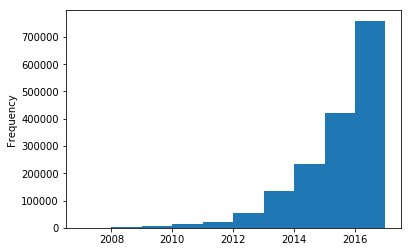

In [4]:
accepted.term = accepted.term.apply(str)
accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])

accepted.issue_d = pd.to_datetime(accepted.issue_d)
accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['issue_yr'].plot.hist()

# Data transformation
I decide to drop several columns because they are a linear combination of others, or they contain too little information.
As for Zip Code, we only have the first 3 number so this feature is not helpful.

In [10]:
accepted = accepted.drop(['title', 'funded_amnt'], axis = 1)
accepted = accepted.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)
accepted = accepted.drop(['fico_range_low', 'last_fico_range_low',
                         'avg_cur_bal',
                         'addr_state', 'initial_list_status', 'pymnt_plan',
                         'application_type', 'hardship_flag', 'disbursement_method',
                          'debt_settlement_flag','sub_grade',
                         'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)

accepted.home_ownership = accepted.home_ownership.replace(['ANY', 'NONE'], 'RENT')

I transform a few variables into the date type for easier analysis later

In [ ]:
accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['earliest_cr_line'] = pd.to_datetime(accepted.earliest_cr_line)
accepted['early_cr_yr'] = accepted.earliest_cr_line.dt.year

accepted.loc[accepted.emp_length == '10+ years', 'emp_length'] = '10 years'
accepted.loc[accepted.emp_length == '< 1 year', 'emp_length'] = '0 year'
accepted.emp_length = accepted.emp_length.apply(lambda x: int(x.split(' ')[0]))

accepted.emp_title = accepted.emp_title.apply(lambda x: x.strip().lower())
accepted.emp_title = accepted.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')

# Exploration Questions
## Change of rates through time
Each loan receives a grade that ranges from G through A. Starting November 2017, grade F and G are no longer used. These codes will plot the average interest rate according to grate through time.

In [5]:
rate = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
rate.shape # 77, 1
rate = rate.reset_index()

Text(0.5,0.98,'Interest Rate over time and grade')

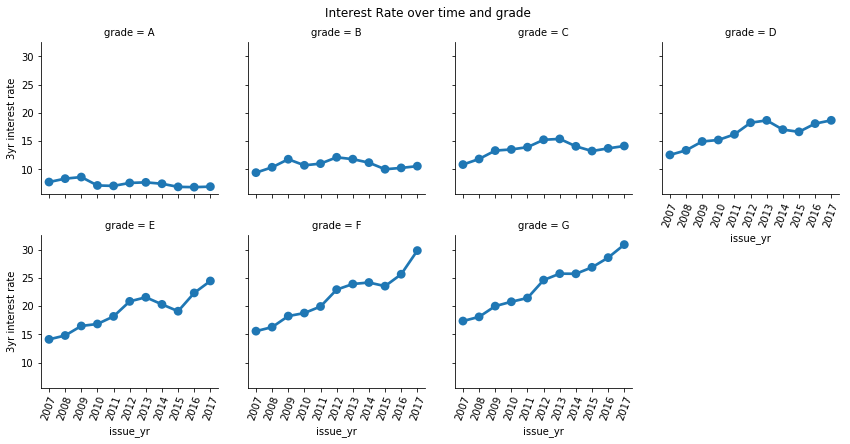

In [6]:
g = sns.FacetGrid(rate, col = 'grade', col_wrap = 4)
g = g.map(sns.pointplot, "issue_yr", "int_rate")

labels = np.arange(2007, 2018, 1)
labels = [str(i) for i in labels]
g = g.set_xticklabels(labels, rotation=70)
g = g.set_ylabels("3yr interest rate")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Interest Rate over time and grade')

We can see that interest rate for grade D, E, F, G increase quickly from 2014. 

We have very few data points from 2007 to 2014. Let's take a closer look to see if this increase in average rate is not due to the small number of observations.


In [7]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

int_rate                                       
grade           A       B      C      D     E     F    G
issue_yr                                                
2007.0         78      98    141     99   100    52   35
2008.0        318     594    580    419   285   111   86
2009.0       1203    1445   1348    817   308   105   55
2010.0       2567    2805   2070   1253   336    91   34
2011.0       5579    4722   2203   1261   272    54   10
2012.0      10753   16805   9902   5088   795   103   24
2013.0      17057   40313  24693  14505  3231   608   15
2014.0      35333   53460  44042  20510  7066  1980  179
2015.0      70132   91783  77457  32740  9450  1363  248
2016.0      66862  114783  92317  36707  9932  2364  530
2017.0      52191   81609  69093  24905  7884  1386  674

The number of loans has increased almost exponentially since inception (which is actually 2007).

## Borrowing purpose

In [ ]:
accepted.purpose.value_counts().sort_values(ascending=False)

## Distribution of Income across Grade
Let's take a leap of faith and only examine the loans where income has been verified. The variable *verification status* can take one of 3 values: Verified, Source Verified or Not Verified. Here I only filtered for loans whose *verification status* is different from 'Not Verified'.

I put a cap on the high income (95% percentile), because the high income level can be in the amount of $500,000, which is not that regular and will distort the chart.

In [9]:
incomeVerified = accepted[accepted['verification_status'] != 'Not Verified'].dropna()
incomeVerified = incomeVerified[['grade','annual_inc']]
quantile_low = incomeVerified['annual_inc'].min()
quantile_high = incomeVerified['annual_inc'].quantile(0.95)
filtered = incomeVerified[(incomeVerified['annual_inc'] > quantile_low) & (incomeVerified['annual_inc'] <= quantile_high)]

(0.0, 2e-05)

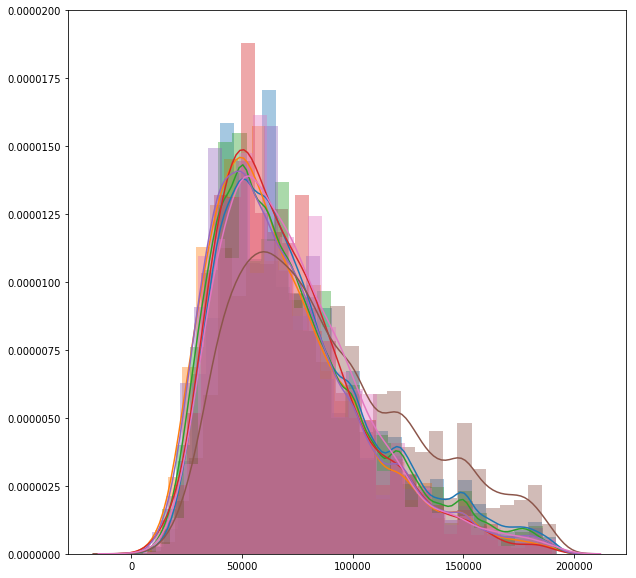

In [10]:
grade_list = filtered['grade'].unique()
plt.figure(figsize=(10,10))
for i in range(len(grade_list)):
    data = filtered[filtered['grade'] == grade_list[i]]['annual_inc'].values
    sns.distplot(data, bins = 30)

plt.ylim(ymax = 0.00002)

There seems to be a slight difference in income level across grade, with one grade has a high density of income above $100,000. Perhaps it may not be beneficial to dive too deep into it, except having a brief look at the median income accross each grade. We do see that while other grades seem to have similar median incomes, grade A does stand out.

In [11]:
# Median of incomes in each grade
income_median = pd.pivot_table(filtered, values = 'annual_inc', index = 'grade', aggfunc = np.median)
income_median

,annual_inc
grade,
A,80000.0
B,67000.0
C,65000.0
D,62000.0
E,61000.0
F,65000.0
G,67000.0


## Income Distribution by Professions

Because of the large number of observations that we have, we can construct a reliable distribution of annual incomes.But first, further transformation:
- Filtering for loans where the reported income is less than 1 million USD
- Filtering for loans where Debt-to-Income ratio is less than 100 percent. If it is greater than or equal to 100, I wonder why we would have made such loans in the first place. I could have been more careful by capping dti value at 100. 
- Changing employment years into numeric
- Filling unknown values for home-ownership as Rent
- Standardizing the values of employment title (emp_title)

In [22]:
leq1mil = accepted['annual_inc'] <= 1e6
accepted = accepted[leq1mil]
accepted = accepted[accepted.dti < 100.0]

AttributeError: 'float' object has no attribute 'strip'

 Because people will most likely lie on their incomes when their income is low, we can filter out for data if:
* Income is lower than \$70,000 but has been verified by Lending Club
* Income is higher than \$70,000 but lower than \$120,000
* Income is higher than \$120,000 but has been verified by Lending Club

The choice of limit of \$70,000 and \$120,000 is arbitrary to filter out loans where income levels seem unrealistic. 

In [21]:
pd.options.display.float_format = '{:,.0f}'.format
salary_limit = 7e4

emp_annual_all = accepted.loc[((accepted['annual_inc'] >= 1.2e5) & (accepted['verification_status'] == 'Verified')) 
                              | ((accepted['annual_inc'] >= salary_limit) & (accepted['annual_inc'] < 1.2e5)) 
                              | ((accepted['annual_inc'] < salary_limit) & (accepted['verification_status'] == 'Verified')),
                              ['emp_title','annual_inc']].groupby('emp_title')


summ_inc = emp_annual_all.agg(['min','mean','median','max', 'count'])
summ_inc.columns = summ_inc.columns.levels[1]
summ_inc = summ_inc.sort_values(by = ['count','min'], ascending = False)

# Filter for professions with more than 500 observations
summ_inc = summ_inc[summ_inc['count'] >= 500].sort_values(by = ['count','min'], ascending = False)
summ_inc

,mean,median,min,max,count
emp_title,,,,,
Teacher,"73,885","75,000","9,000","367,500",13479
Manager,"85,749","83,000","12,000","1,000,000",13086
Registered Nurse,"85,549","82,940","10,900","320,000",7458
RN,"85,431","82,000","18,597","285,000",7263
Owner,"94,794","85,000","5,000","1,000,000",6554
Supervisor,"77,233","75,000","14,900","780,000",5627
Project Manager,"92,724","90,000","22,000","460,000",5584
Sales,"88,431","80,000","10,000","650,000",4750
Driver,"73,725","75,000","7,000","1,000,000",4743


This dataset does have a large diversity in the professions and income level of borrowers. Personally, what I find most interesting is that:

- Teacher and Nurse, despite being regarded as respectable professions in some regions in the world, are the 2 most common professions on Lending Club. Their minimum salary is only around \$12,000, which is lower than US' Poverty Level for individual.
- Police officer has a minimum salary of \$32,000
- Many people with annual income higher than \$400,000 and even \$1,000,000 still use Lending Club as a way to borrow cheaply. I can dive down into the purpose of the loans later, but that may not offer much benefit for data modeling.
- Some job traditionally associated with high income has very min income, such as attorney, director, enginee. And these salaries have been verified by Lending Club. It's likely that these salaries miss a 0's. This is worthy of attention.

## Fico range and grade
As we have seen in the previous workbook, income distribution is similar across loan grade while income for grade A is a little bit higher.

In [ ]:
accepted.boxplot(by = 'grade', column = 'fico_range_high')

The change in FICO score may be associated with the loans. While I cannot observe how FICO will change over time, it will be an interesting visualization. 

In [ ]:
fico_change_loanstat = accepted.loc[accepted.loan_status != 'Current',
                                    ['fico_range_high','last_fico_range_high','loan_status','target']]
# Change in FICO score
fico_change_loanstat['change'] = fico_change_loanstat.last_fico_range_high - fico_change_loanstat.fico_range_high

chargeoff = accepted['target'] == 1

plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[~chargeoff], color = 'r', alpha = 0.1, label = "Good loans")
plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[chargeoff], color = 'b', alpha = 0.2, label = "Bad loans")
plt.legend()
plt.xlabel("FICO at origination")
plt.ylabel("FICO change at observation")

We can easily see that Bad Loans can happen regardless of FICO score at origination. However, loans where the FICO score is lower than 750 is disproportionately more likely to become a bad loan. 

## Charge off rate vs Verification status
My hypothesis is that Lending Club tends to take the effort to verify a borrower's income only when it is _high_. To quickly examine this hypothesis, I look at the charge off rate across each grade depending on whether the income is Verified or not.

I define that a loan is considered charge-off when the value of *loan_status* is Charged Off or Default. I can expand it to 90 days behind dues, but it does not make that large of a difference.

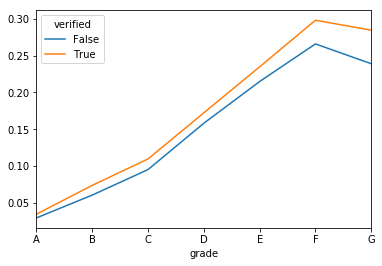

In [8]:
accepted['verified'] = accepted['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(accepted,index=["grade","verified"], values=['funded_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(accepted[(accepted.loan_status == 'Charged Off') | (accepted.loan_status == 'Default')],
                                           index=["grade","verified"], values=['funded_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default.columns = ['Charged_off']

loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)
loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['funded_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()


Based on the graph, we can safely reject my hypothesis. Loans that have verified income actually has a high level of charge-off. It is reasonable to assume that these loans are often associated with lower level of income, hence higher charge-off. 

The graph also show that the charge-off rate changes almost linearly from grade A (highest grade) through grade G. The charge-off rate for grade F-G is approximately 25%. To compare, this is still lower than that historic default rate of non-investment grade bond, which is higher than 30% ([Wikipedia Credit Rating](https://en.wikipedia.org/wiki/Bond_credit_rating).)


# Modeling
With the status of being a Good or Bad Loan our variable of interest, we can approach this as a classification problem. This is still an exploratory phase so please excuse the haphazard approach. First, define our target:

In [ ]:
accepted = accepted.loc[accepted.loan_status != 'Current', :]
accepted['target'] = 1
accepted.loc[(accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'In Grace Period'), 'target'] = 0

Let's see the columns that we have:

In [ ]:
accepted.columns

Generally, *bc* stands for bank cards. *il* stands for installment.
*num_actv_bc_tl* is number of active bank card accounts.

I calculate a few more variables:
- *Balance_annual_inc* is the ratio of current balance over annual income, similarly for *install_annual*.
- *install_loan_ratio* is the ratio of monthly installment / loan amount. This should be very similar to rate, and therefore to the grade of the loan
- *disposable_inc* is the amount of disposable income each month after mortgage payment and payment for Lending Club loans
- *dti_new* is *disposable_inc* \* 12 / *annual_inc*

I plan to approach using a series of tree-model, which does not handle well the difference and interaction between features. 

In [ ]:
# Assuming that if borrowing for debt consolidation, they actually have more disposable income
accepted.loc[:, 'temp'] = np.where((accepted.purpose == 'debt_consolidation') | (accepted.purpose == 'credit_card'),0.5, -1.0)
accepted.loc[:, 'disposable_inc'] = (1 - accepted['dti']/100)*accepted['annual_inc']/12 + accepted['temp'] * accepted['installment']    
accepted.loc[:, 'disposable_ratio']= accepted['disposable_inc']*12/ accepted['annual_inc']

accepted.drop('temp', axis = 1)

accepted_train.loc[:, 'cr_yr_before_loan'] = accepted_train['issue_yr'] - accepted_train['earliest_cr_yr']

accepted['log_annual_inc'] = np.log(accepted.annual_inc)
accepted['log_installment'] = np.log(accepted.installment)

accepted['install_loan_ratio'] = accepted['installment'] / accepted['loan_amnt']
accepted['balance_annual_inc'] = accepted['loan_amnt'] / accepted['annual_inc']
accepted['install_annual'] = accepted['installment'] / accepted['annual_inc']

In [ ]:
selected_features = ['loan_amnt', 'term', 'int_rate', 'installment'
            # , 'grade' - grade is dropped because it is highly correlated with int_rate
            ,'emp_length', 'home_ownership', 'annual_inc', 'verification_status'
            # ,'issue_d'
            # , 'purpose'
            ,'dti', 'delinq_2yrs'
            ,'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal'
            ,'revol_util', 'total_acc'
            #, 'out_prncp', 'total_pymnt', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee'
            #,'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
            #,'last_fico_range_high', 'collections_12_mths_ex_med', 'acc_now_delinq'
            #,'tot_coll_amt', 
            ,'tot_cur_bal', 'total_rev_hi_lim','acc_open_past_24mths', 'bc_open_to_buy', 'bc_util'
            ,'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct'
            ,'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl'
            ,'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd'
            ,'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl'
            ,'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0'
            ,'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m'
            ,'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'
            ,'pub_rec_bankruptcies', 'tot_hi_cred_lim'
            ,'total_bal_ex_mort'
            ,'total_bc_limit', 'total_il_high_credit_limit'
            #,'issue_yr'
            #,'earliest_cr_yr'
            ,'loan_status','target'
            ,'cr_yr_before_loan'
            ,'log_annual_inc', 'log_installment'
            ,'disposable_inc', 'install_loan_ratio', 'disposable_ratio', 'balance_annual_inc'
            ,'install_annual']

Create testing and training set: I can use train_test_split, but I decide to be more realistic and see what happen if I use the training data until 2016 and test on the data in 2017. In reality, there should probably be another validation set, for example: training data only lasts until 2015, then 2016 data is used as validation. 

In [ ]:
accepted_train_clean = accepted.loc[accepted.issue_yr != 2017, :]
accepted2017_clean = accepted.loc[accepted.issue_yr == 2017, :]
print("Training size", accepted_train_clean.shape)
print("Testing size", accepted2017_clean.shape)

In [ ]:
## In my experiments, I actually output these 2 datasets so that 
## I can come back to them with ease instead of having to run the whole workbook again
# accepted_train_clean.to_csv(ROOT_PATH + './input_clean/train.csv', index = False)
# accepted2017_clean.to_csv(ROOT_PATH + './input_clean/test.csv', index = False)

## Helper function
Define a few helper function:

In [ ]:
def GetAUC(model, X_train, y_train, X_test, y_test):
    '''
    To quickly get the AUC of model on the training and testing set
    '''
    res = [0.0, 0.0]
    y_train_score = model.predict_proba(X_train)[:, 1]
    res[0] = metrics.roc_auc_score(y_train, y_train_score)
    print("In sample", res[0])
    
    y_test_score = model.predict_proba(X_test)[:, 1]
    res[1] = metrics.roc_auc_score(y_test, y_test_score)
    print("Out of sample", res[1])
    
def GetXY(df, features):
    '''
    Select the subset of features
    Create dummy variables if needed
    '''
    df = df.loc[:, features]

    categorical_features = ['term', 'home_ownership', 'verification_status']
    
    for cat_feature in categorical_features:
        if cat_feature in train.columns:
            train = pd.get_dummies(train, prefix = [cat_feature], columns = [cat_feature], drop_first = True)
            
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    
    return X, y

In [ ]:
X, y = GetXY(accepted_train_clean, selected_features)
X_test, y_test = GetXY(accepted2017_clean, selected_features)

## Baseline model
Please follow Vince Poceta's workbook. I expected the AUC to be around 0.65.

## Simple feature selection
I feel that 100 features are too much for this kind of problem. I will attempt to fit Gradient Boosting and Random Forest on this data as some form of simple Feature Selection method. There are other established methods, like Boruta, but the computation is also much more.

In [ ]:
gbm = GradientBoostingClassifier(max_depth = 6, n_estimators= 400, max_features = 0.3)
gbm.fit(X, y)
GetAUC(gbm, X, y, X_test, y_test)

In [ ]:
rfc = RandomForestClassifier(max_depth = 6, n_estimators= 400, class_weight = {0: 1, 1:10})
rfc.fit(X, y)
GetAUC(gbm, X, y, X_test, y_test)

Let's check the feature importance from these 2 models. I mainly pay attention to *Max of feature importance* divided by the feature importances. As such, the feature with the highest feature importance will receive a value of 1, and the feature will lowest feature importance will receive a large value.

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
feature_imp = pd.DataFrame({'name': X.columns, 'imp': gbm.feature_importances_}).sort_values(by = 'imp', ascending = False)

feature_imp['mult_gbm'] = feature_imp.imp.max() / feature_imp['imp']
feature_imp['mult_rfc'] = rfc.feature_importances_.max() / rfc.feature_importances_

feature_imp.to_csv(ROOT_PATH + './model_run/feature_importance.csv')

From testing the model, I feel that GBM can easily overfit the data, plus the feature importance from GBM mostly make sense, so I put my faith in this. 

Even though I should not pay too much attention in the scale of the feature importance, I feel that a difference of 6 times in magnitude may signify something, so I only select a subset 

In [ ]:
selected = feature_imp.loc[feature_imp.mult_gbm < 6, ['name','mult_gbm']]
X_reduced = X[selected.name.values]
X_test_reduced = X_test[selected.name.values]

X_reduced.shape
X_reduced.columns

## Model

It appears that we no longer have any categorical data such as Homeownership. Now I attempt a series of test to see if I can improve the model's AUC. In practice, I should pay attention to other criteria such as F1 and recall as well. The list of models that I have tried:
- Logistic Regression: both used in Google and Facebook's CTR prediction 
- GBM: the work horse, I can over fit the data and see what may happen
- Mas-o-Menos: simple classification techniques by researchers at Harvard University. I read about this technique in the paper 50 years of Data Science as  an illustration of a simple, effective techique that trumps many other complicated algorithms in practice. Not surprisingly, this simple technique performs quite well for this dataset.
- Scale the data in multiple way:
> Standard Scaler: which I am very skeptical of if I have any categorical data <br>
> a Scaling method from Airbnb <br>
> Combination between Scaling and Over / Undersampling <br>


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

class MasOrMenos(BaseEstimator):
    def __init__(self):
        self.NumFeatures = 0
        self.coeffs = None
        self.model = LogisticRegression()
        
    def fit(self, X_train, y_train):
        self.NumFeatures = X_train.shape[1]
        sqrtNumFeatures = np.sqrt(self.NumFeatures)
        self.coeffs = [0.0] * self.NumFeatures
        for i in range(self.NumFeatures):
            self.model.fit(X_train.iloc[:, i:(i+1)], y_train)
            self.coeffs[i] = np.sign(self.model.coef_[0]) / sqrtNumFeatures
        
        self.coeffs = np.array(self.coeffs).reshape(-1,1)
    
    def sigmoid(self, x):
        return (1/ (1 + np.exp(-x)))

    def predict_proba(self, X_test):
        tmp = np.zeros((X_test.shape[0], 2))
        tmp[:, 1] = self.sigmoid(np.matmul(X_test, self.coeffs))[:,0]
    
        return tmp
    
    def predict(self, X_test):
        return self.predict_proba(X_test)[:, 1]

In [ ]:
modelList = {'mm': MasOrMenos()
             ,'rfc':rfc = RandomForestClassifier(n_estimators= 300, max_depth = 5, class_weight = {0: 1, 1:10})
             ,'logistic': linear_model.LogisticRegression()
             ,'logistic_l1_05': linear_model.LogisticRegression(penalty='l1')
             ,'logistic_l1_4': linear_model.LogisticRegression(penalty='l1', C = 4.0)
             ,'gbm': GradientBoostingClassifier(max_depth = 5, n_estimators= 300, subsample = 0.8, max_features = 0.5)
             ,'gbm_overfit': GradientBoostingClassifier(max_depth = 10, n_estimators= 300,
                                   subsample = 0.8, max_features = 0.5)
            }

### Rescaling
I attempt a feature engineering method from Airbnb [here](https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba) and transform all features into 0 and 1 scale, basically:
$$x\Rightarrow Pr(X \leq x \| Y = 1)$$
Luckily, my reduced set of features are all numerical. 

In [ ]:
### Standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardScaled = scaler.fit_transform(X_reduced)
X_test_standardScaled = scaler.transform(X_test_reduced)

In [ ]:
### Airbnb Scaler
X_reshaped_target = X_reduced[y == 1]
print("Shape of the referenced dataset", X_reshaped_target.shape)

def Transform_to_CDF(data_, compare):
    data_sorted = data_.sort_values()
    data = data_sorted.values
    
    compare = compare.sort_values().values
    output = [0] * len(data)
    idx_data = 0
    idx_compare = 0
    loop = True
    
    tmp = 0
    
    while loop:
        if idx_compare == len(compare):
            if idx_data < len(data):
                for i in range(idx_data, len(data)):
                    output[i] = tmp    
            break
        if idx_data == len(data):
            break
        if data[idx_data] < compare[idx_compare]:
            output[idx_data] = tmp
            idx_data += 1
        else:
            tmp += 1
            idx_compare += 1
    
    output = pd.Series(output, index = data_sorted.index)
    return output[data_.index]

X_bnbScaled = X_reduced.copy()
for i in range(X_reduced.shape[1]):
    X_bnbScaled.iloc[:, i] = Transform_to_CDF(X_reduced.iloc[:, i], X_reshaped_target.iloc[:, i])
X_bnbScaled = X_bnbScaled / X_reshaped_target.shape[0]

X_test_bnbScaled = X_test_reduced.copy()
for i in range(X_test_reduced.shape[1]):
    X_test_bnbScaled.iloc[:, i] = Transform_to_CDF(X_test_reduced.iloc[:, i], X_reshaped_target.iloc[:, i])
X_test_bnbScaled = X_test_bnbScaled / X_reshaped_target.shape[0]

In [ ]:
### Apply sampling method
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=1234)
underSampler = RandomUnderSampler(random_state=1234)

X_standardScaled_smote, y_standardScaled_smote = smote.fit_sample(X_standardScaled, y)
X_bnbScaled_smote, y_bnbScaled_smote = smote.fit_sample(X_bnbScaled, y)

X_standardScaled_underSample, y_standardScaled_underSample = underSampler.fit_sample(X_standardScaled, y)
X_bnbScaled_underSample, y_bnbScaled_underSample = underSampler.fit_sample(X_bnbScaled, y)

In [ ]:
# Run models
dataList = {
    'base': [X_reduced, y, X_test]
    ,'standardScaled': [X_standardScaled, y
                        , X_test_standardScaled]
    ,'bnbScaled': [X_bnbScaled, y
                   , X_test_bnbScaled]
    ,'standardScaled_smote': [X_standardScaled_smote, y_standardScaled_smote
                              , X_test_standardScaled]
    ,'standardScaled_underSample': [X_standardScaled_underSample, y_standardScaled_underSample
                                    , X_test_standardScaled]
    ,'bnbScaled_smote': [X_bnbRescaled_smote, y_bnbRescaled_smote
                         , X_test_bnbRescaled]
    ,'bnbScaled_underSample':[X_bnbRescaled_underSample, y_bnbRescaled_underSample
                              , X_test_bnbRescaled]
}

cols = ['model','In sample','Test sample','runtime']
models_report = pd.DataFrame(columns = cols)

In [ ]:
for model in modelList: 
    for trainData in dataList:
        start = time.time()
        thisModel = modelList[model]
        thisModel.fit(dataList[trainData][0], dataList[trainData][1])
        runtime = (time.time() - start) / 60
        
        joblib.dump(thisModel, ROOT_PATH + './model_run/' + model + '_' + trainData + '.pkl')
        
        y_score = thisModel.predict_proba(dataList[trainData][0])[:, 1]
        y_test_score = thisModel.predict_proba(dataList[trainData][2])[:, 1]
        
        tmp = pd.Series({'model_type': model,
                         'In sample': metrics.roc_auc_score(dataList[trainData][1], y_score),
                         'Test sample' : metrics.roc_auc_score(y_test, y_test_score),
                         'runtime': runtime,
                         })

        models_report = models_report.append(tmp, ignore_index = True)

models_report.to_csv(ROOT_PATH + './model_run/' + 'models_report.csv' )
models_report